In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

from xgboost import XGBRegressor
from jcopml.tuning import random_search_params as rsp
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual

import pickle

%matplotlib inline

c:\Users\Nostics\miniconda3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Data

In [2]:
df = pd.read_csv("data/car_prices_train.csv")
df.head()

,make,model,year,mileage,price,color,state,date
0,Nissan,Fusion,2016,35656,15820,black,CA,2023-09-30 23:02:01.648867
1,Ford,Altima,2010,72079,10539,silver,FL,2023-04-09 23:02:01.649616
2,Honda,Accord,2014,38851,10247,blue,CA,2023-09-16 23:02:01.649693
3,Ford,Accord,2018,20835,25712,white,IL,2023-11-03 23:02:01.649710
4,Ford,Accord,2015,57307,22564,silver,FL,2023-03-08 23:02:01.649313


In [3]:
### Drop Colom Date
df.drop(columns="date", inplace=True)
df.head()

,make,model,year,mileage,price,color,state
0,Nissan,Fusion,2016,35656,15820,black,CA
1,Ford,Altima,2010,72079,10539,silver,FL
2,Honda,Accord,2014,38851,10247,blue,CA
3,Ford,Accord,2018,20835,25712,white,IL
4,Ford,Accord,2015,57307,22564,silver,FL


# Quick EDA

### Check Missing Value

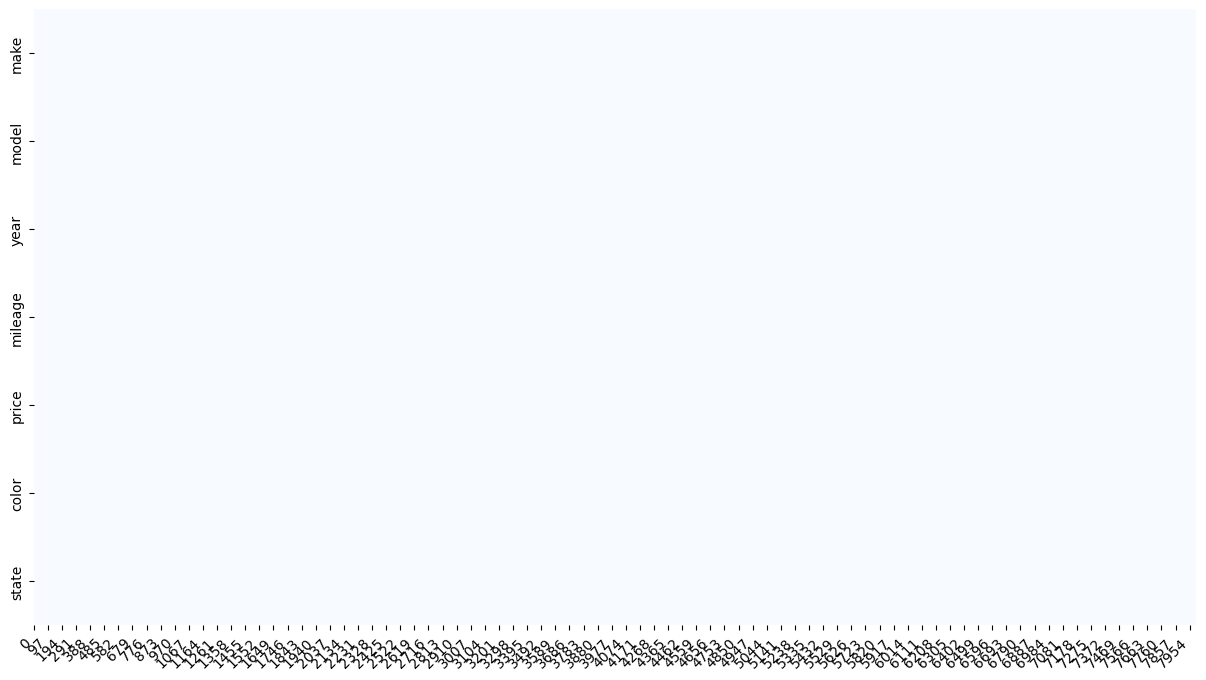

In [4]:
plot_missing_value(df)

### Statistics

In [6]:
df.describe()

,year,mileage,price
count,8000.000000,8000.000000,8000.000000
mean,2013.842875,55624.924875,29319.816750
std,2.626271,25115.297964,11682.889446
min,2010.000000,10284.000000,10022.000000
25%,2011.000000,34825.000000,19003.000000
50%,2014.000000,55674.000000,29372.000000
75%,2016.000000,77133.000000,39237.000000
max,2018.000000,99783.000000,49998.000000


### Histogram

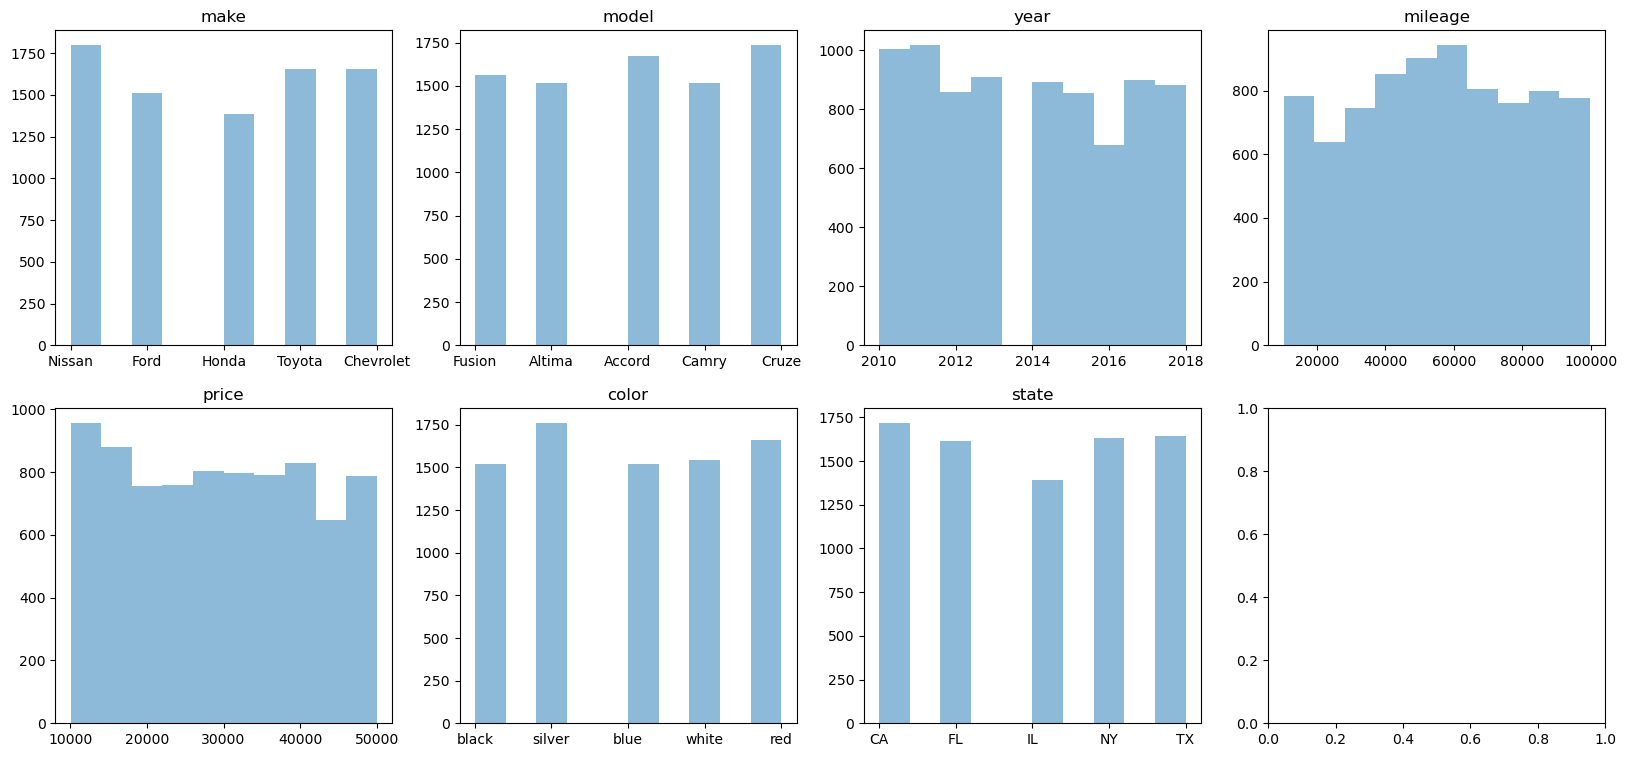

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,9))

for col, ax in zip(df.columns, axes.flatten()):
    ax.hist(df[col], alpha=0.5)
    ax.set_title(col)

### Scatter plot

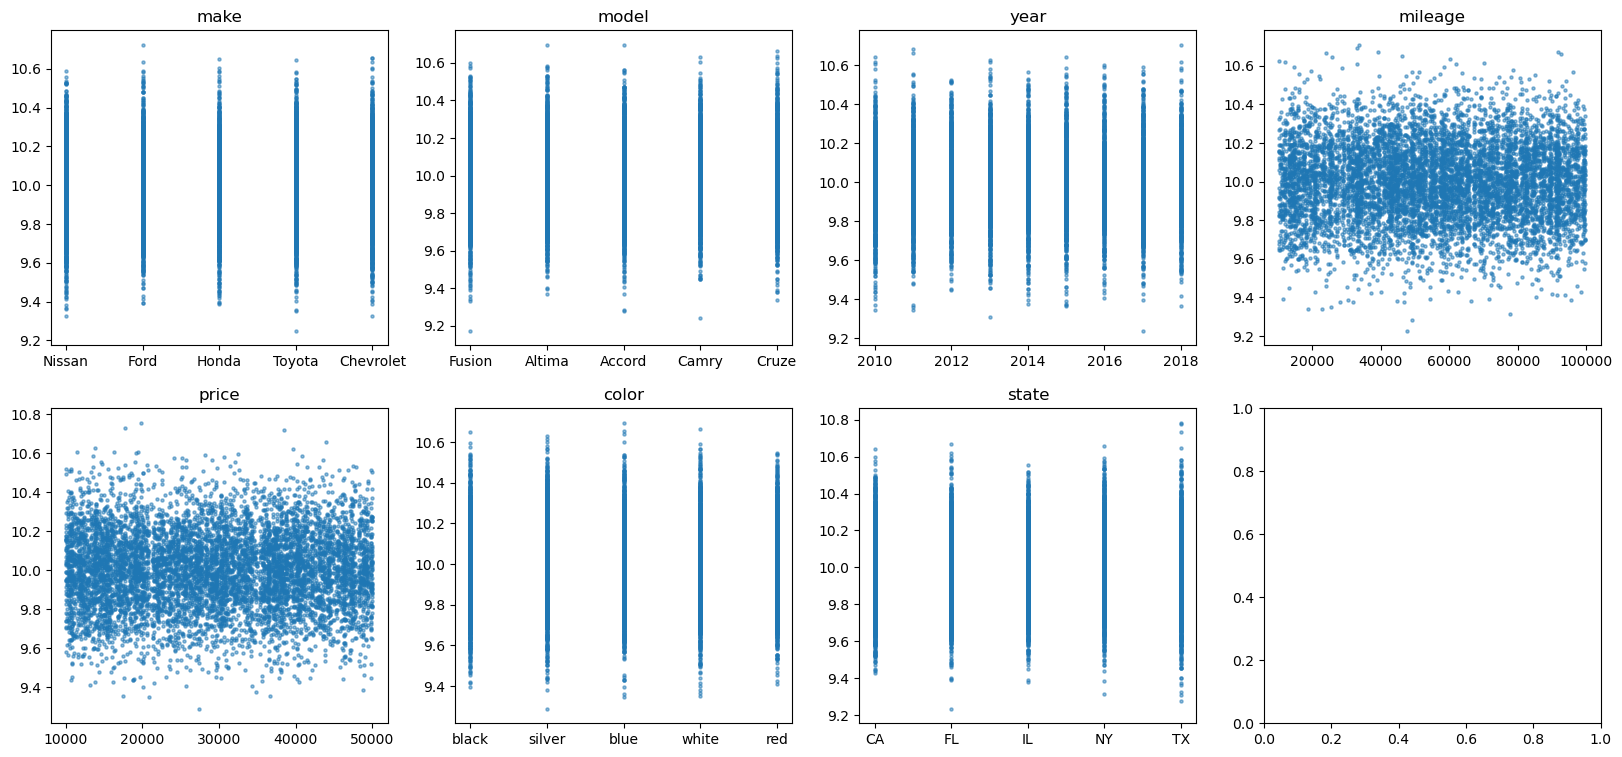

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,9))

for col, ax in zip(df.columns, axes.flatten()):
    ax.scatter(df[col], np.random.normal(10, 0.2, size=df.shape[0]), alpha=0.5, s=5)
    ax.set_title(col)

### Countplot

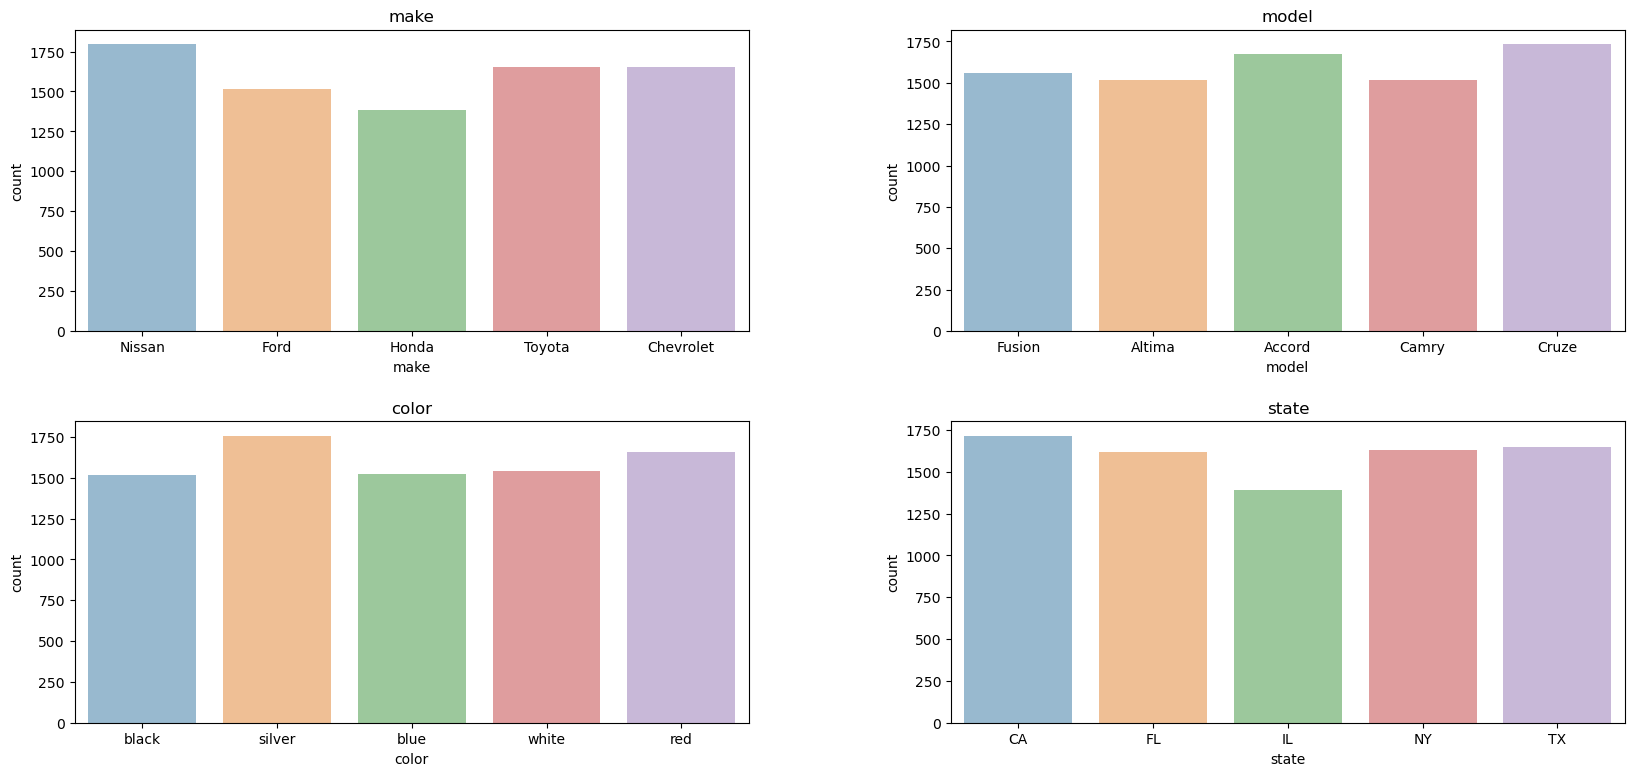

In [9]:
cols = [col for col in df.columns if df[col].dtype == "object"] # object cols

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,9))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for col, ax in zip(df[cols], axes.flatten()):
    sns.countplot(x=col, data=df, alpha=0.5, ax=ax)
    ax.set_title(col)

**Everything looks good :)**

# Dataset Splitting

In [10]:
X = df.drop(columns="price")
y = df.price

# Preprocessing

In [11]:
num_data = Pipeline([
    ("impute", SimpleImputer()),
    ("transformer", PowerTransformer())
])

cat_data = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ("numeric", num_data, [col for col in X.columns if X[col].dtype == "int64" or X[col].dtype == "float64"]),
    ("categoric", cat_data, [col for col in X.columns if X[col].dtype == "object"])
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

# Training

In [ ]:
# reg = RandomizedSearchCV(pipeline, 
#                          param_distributions=rsp.xgb_params,
#                          cv=3,
#                          n_iter=50,
#                          verbose=1,
#                          random_state=42)
# reg.fit(X, y)

# print(reg.best_params_)
# print(reg.score(X, y), reg.best_score_)

# Evaluation

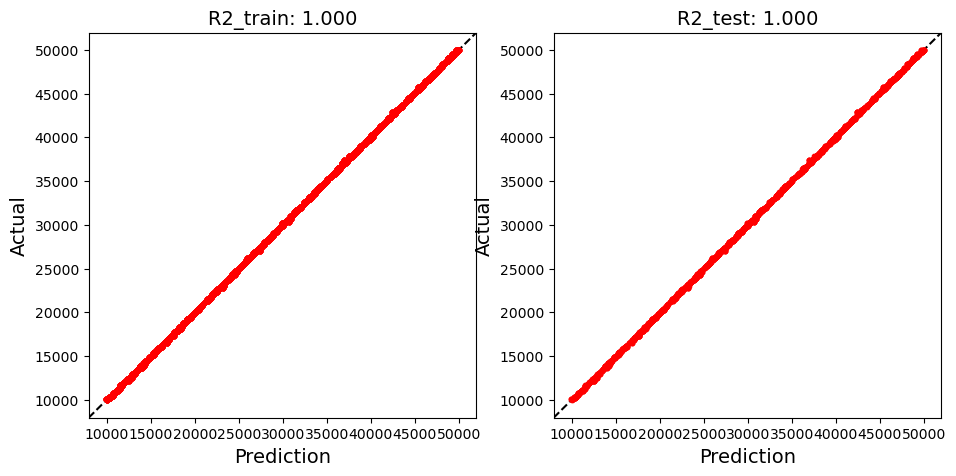

In [17]:
plot_actual_vs_prediction(X, y, X_test, y_test, reg)

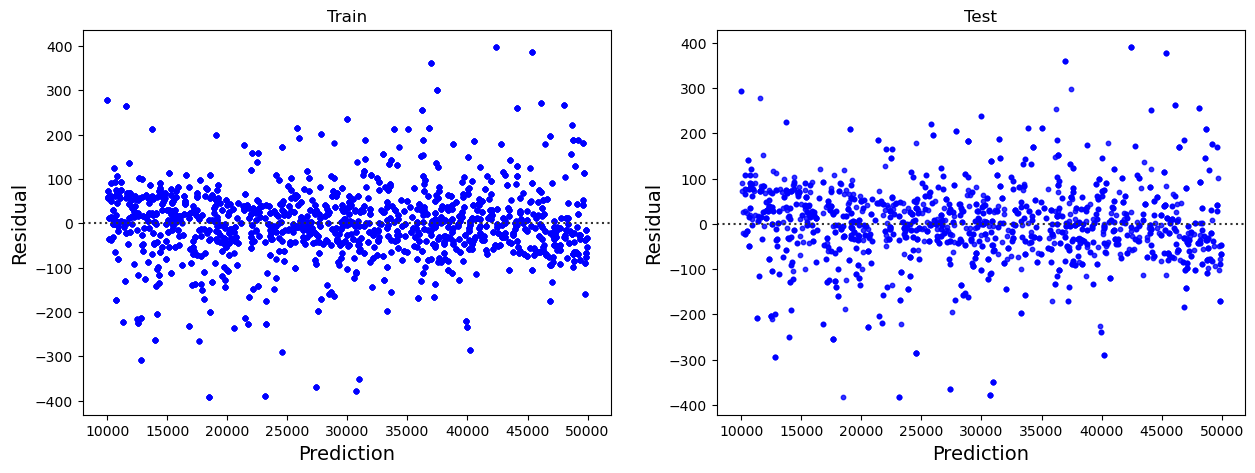

In [20]:
plot_residual(X, y, X_test, y_test, reg)

In [ ]:
# Save Model
with open("model/xgb-reg-car.pkl", "wb") as file:
    pickle.dump(reg, file)

# Testing

In [12]:
# Load Model
with open("model/xgb-reg-car.pkl", "rb") as file:
    reg = pickle.load(file)

In [14]:
data_test = pd.read_csv("data/car_prices_test.csv")
data_test.drop(columns="date", inplace=True)
data_test.head()

,make,model,year,mileage,price,color,state
0,Toyota,Cruze,2017,19882,34176,red,IL
1,Ford,Cruze,2016,95349,26655,red,NY
2,Toyota,Accord,2017,23744,10359,silver,IL
3,Honda,Fusion,2014,55370,23514,white,CA
4,Honda,Cruze,2013,41146,27168,red,IL


In [16]:
X_test = data_test.drop(columns="price")
y_test = data_test.price

y_pred = reg.predict(X_test)

# Score
print(reg.score(X_test, y_test))

0.9999083486153111


# Add predicted to Dataframe

In [ ]:
data_test["price_pred"] = np.round(y_pred)
data_test

In [ ]:
# Error Price (Actual price - Predicted price)
"""if error_price < 0:
        actual less than predicted
    if error_price > 0:
        actual more than predicted
"""
data_test["error_price"] = data_test.apply(lambda x : x.price - x.price_pred, axis=1)
"""
    Error = |(actual - predicted) / actual| * 100
"""
data_test["error_percentase"] = data_test.apply(lambda x : 
                                                round(number=np.abs((x.price - x.price_pred) / x.price) * 100,
                                                      ndigits=2), axis=1)

data_test